---
layout:     post
title:      "Dollars to Doughnuts"
subtitle:   "How far does my food dollar go?"
date:       2017-04-06 12:00:00
author:     Andrew
header-img: img/posts/food_spending/peppers_bg.jpg
header-credit: https://unsplash.com/@mobography
tags:       programming dynamics sympy python
---

This is a quick post to do some visualization on some of my financial data.  I was interested in determining if some concious changes I had been making to my food spending habits had actually materialized into real savings.

Everyone's always looking to find a place to save a few dimes, and over the past few months I've really started to take notice of my food spending.  After examining the last few months worth of budgets (I use mint to track my expenses and categorize them), I decided to make a concerted effort to eat out less, cook more and bring my lunch to work to reduce spending.

I started this effort roughly around mid February, but I'll look at the data starting at last October to give some historical trends.

Fine print:
* I was on vacation in the beginning of January, using cash only, so those transactions won't appear
* I didn't remove anomolies, like covering a meal for a group and getting paid in cash
* Some restaurants show up in Alcohol & Bars


I use [mint](https://www.mint.com/) to track and categorize my finances.  It pulls transaction information from my bank accounts, and each month I run through the transactions from the previous month to make sure they were correctly categorized.  

For the analysis, I used my programming language of choice, [python](https://www.python.org/), with the [matplotlib](http://matplotlib.org/), [numpy](http://www.numpy.org/), and [scipy](https://www.scipy.org/) libraries.

This post will be interleaving the code and my rationale, so if you're not particularly interested in the code, you can skip over those sections.  I've done my best to make it a coherent article even without the code.  The code to create the plots is very verbose, so it's definitely safe to skip that.

This first code block is just setting everything up and importing all the necessary libraries.

In [1]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import datetime, timedelta, date
from itertools import groupby, dropwhile, accumulate
from decimal import Decimal, getcontext
from pprint import pprint
from scipy import stats

%matplotlib inline

getcontext().prec = 6
preview_size = 5

mpl.rcParams['figure.figsize'] = (12.0, 10.0)
mpl.rcParams['font.size'] = 15

# Getting The Data

To start, I downloaded all my transactions from mint as a .csv (comma separated values) file. In excel, I removed everything except the columns for date, amount and category. I could have done some of that in python, but it was just easier to do it ahead of time.

Now in python, let's read in the file.  Python's `csv` module makes it easy to already separate the data.  The result is a list of all the rows, each of which is already split up into the columns.

In [2]:
with open('transactions.csv','r') as transactions_csv:
    transactions = list(csv.reader(transactions_csv, delimiter=','))
    

pprint(transactions[:preview_size])

[['Date', 'Amount', 'Category'],
 ['4/06/2017', '1.34', 'Lunch at Work'],
 ['4/06/2017', '2.55', 'Lunch at Work'],
 ['4/05/2017', '7.22', 'Restaurants'],
 ['4/05/2017', '10.25', 'Movies & DVDs']]


The first step to make the data usable is to remove the column header text.  Indexing `transactions` by `[1:]` will take everything in `transactions` except the first row (python indexing starts at `0`).

In [3]:
transactions = transactions[1:]

pprint(transactions[:preview_size])

[['4/06/2017', '1.34', 'Lunch at Work'],
 ['4/06/2017', '2.55', 'Lunch at Work'],
 ['4/05/2017', '7.22', 'Restaurants'],
 ['4/05/2017', '10.25', 'Movies & DVDs'],
 ['4/06/2017', '1.18', 'Lunch at Work']]


Right now, all the data is being stored as strings, which makes it difficult to do any kind of sorting or math.

To resolve this, let's make a new class (`Transaction`) to store this information.  This way, data types can also be assigned to the individual pieces of information as well.

The attributes of `Transaction` will be:
* **date**: `datetime.strptime` turns a string into an actual date object in python, so we can filter and sort by date.
* **amount**: will be stored as `Decimal` (don't use floating point for currencies![^floating_bitcoin])
* **category**: will remain a string.

Additionally, I'll add a `__str__` method to make things look nice when they get printed out.

In [4]:
class Transaction(object):
    
    def __init__(self, date, amount, category):
        self.date = datetime.strptime(date,"%m/%d/%Y")
        self.amount = Decimal(amount)
        self.category = category
    
    def __str__(self):
        return "${0:>6.2f} on {1:>8} ({2})".format(
            self.amount,
            self.date.strftime("%m/%d/%y"),
            self.category)
    
    def __repr__(self):
        return self.__str__()

In [5]:
transactions = [Transaction(date, amount, category) for date, amount, category in transactions]

pprint(transactions[:preview_size])

[$  1.34 on 04/06/17 (Lunch at Work),
 $  2.55 on 04/06/17 (Lunch at Work),
 $  7.22 on 04/05/17 (Restaurants),
 $ 10.25 on 04/05/17 (Movies & DVDs),
 $  1.18 on 04/06/17 (Lunch at Work)]


The transaction list still contains every transaction in my transaction history on mint, so we'll need to filter out the non-food related one.  Here is the list of the food categories that I track in mint.

In [6]:
food_categories = ['Alcohol & Bars',
'Coffee Shops',
'Fast Food',
'Groceries',
'Restaurants',
'Lunch at Work',
'Snacks']

transactions = [trans for trans in transactions if trans.category in food_categories]

pprint(transactions[:preview_size])

[$  1.34 on 04/06/17 (Lunch at Work),
 $  2.55 on 04/06/17 (Lunch at Work),
 $  7.22 on 04/05/17 (Restaurants),
 $  1.18 on 04/06/17 (Lunch at Work),
 $  1.71 on 04/05/17 (Lunch at Work)]


Lastly, let's make sure the data is sorted (this is important later when we want to group the data).  This will sort the transactions first by date, then by category for transactions that happen on the same date.

In [7]:
transactions.sort(key = lambda trans: (trans.date, trans.category))

pprint(transactions[:preview_size])

[$  4.00 on 09/17/10 (Restaurants),
 $  7.68 on 09/17/10 (Restaurants),
 $ 11.95 on 09/19/10 (Restaurants),
 $ 10.50 on 09/20/10 (Alcohol & Bars),
 $ 81.22 on 09/29/10 (Fast Food)]


Next, let's trim our date range down to something recent.  We can start with last October.  That will give some historical data, but not enough that we can't see a trend over the last few months.

In [8]:
cutoff_date = datetime(day=1, month=10, year=2016)

transactions = [trans for trans in transactions if trans.date >= cutoff_date]

Now our data looks something like this:

In [9]:
pprint(transactions[:preview_size])

[$ 35.16 on 10/01/16 (Alcohol & Bars),
 $  9.92 on 10/01/16 (Alcohol & Bars),
 $  2.12 on 10/01/16 (Fast Food),
 $ 16.70 on 10/01/16 (Groceries),
 $  6.20 on 10/01/16 (Lunch at Work)]


`transactions` is now a list of all transactions, sorted by date.  The first thing we should look at is a simple bar graph of daily spending.  I anticipate that it won't be particularly informative (might be very noisy), but it might spot if we've done something wrong manipulating the data to this point.

In order to do this, we first need to group the transactions by date.  Python has a function `groupby`, which does exactly this, but requires that the data be sorted (which we've already done).

Once the transactions are grouped by date, they're summed up and the dates and amounts are added to lists for plotting later.

In [10]:
grouped_transactions = groupby(transactions, key = lambda trans: trans.date)

dates = []
daily_sums = []

for date, transaction_group in grouped_transactions:
    dates.append(date)
    daily_sums.append(sum([trans.amount for trans in transaction_group]))

# Daily Spending

(This code is just to make pretty pictures)

In [11]:
def format_x_axis_dates(fig, ax):
    days = mdates.DayLocator()
    months = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%B %-d')
    
    fig.autofmt_xdate()
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(days)

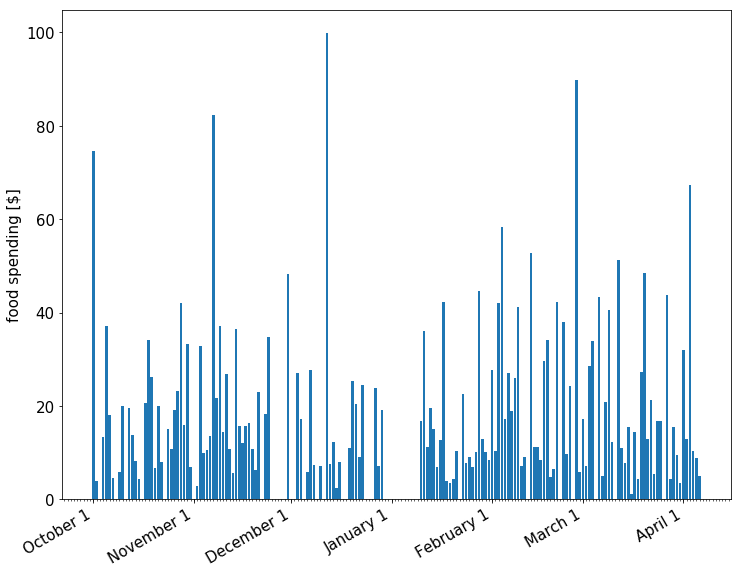

In [12]:
fig, ax = plt.subplots(1)
ax.bar(dates, daily_sums)
plt.ylabel("food spending [$]")
format_x_axis_dates(fig, ax)
plt.show()

As expected, the data looks reasonable, but not particularly informative to spot any trends.  There's just too much daily fluctuation.

# Rolling Average Daily Spending

Because of these short term fluctuations, a different approach might yield more information.

Conveniently, just such an approach exists.  Moving averages are commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles[^wiki_ma].  In this case, I'll be using a moving average to average my spending over the previous `30` days.

We'll be using a simple un-weighted moving average, where the data for a particular date represents the un-weighted average spending over the previous 30 days.

`calculate_rolling_window_sums` is the function that will actually do the calculation, given a list of dates, daily sums for those dates, and a requested time span to do the averaging over.

In [13]:
def calculate_rolling_window_sums(dates, daily_sums, time_span):

    # index will be the date that we'll use to loop through our data
    # it starts time_frame days from the beginning, which the first 
    # day that we have enough data to average.  index is the end of
    # our window on each calculation.
    start = dates[0]
    end = dates[-1]
    
    index = start + timedelta(days = time_span-1)

    rolling = []
    rolling_dates = []
    
    # stop once the index has reached the last day, stop calculating.
    while index <= end:

        # on each loop, filter out any transactions that don't fall in our window
        window = [trans for trans in transactions
                  if index - timedelta(days = time_span) <= trans.date <= index]

        # sum all transactions that fall in the window
        # then average them
        # then add that average to our result
        rolling.append(sum([trans.amount for trans in window])/time_span)

        # we're also keeping track of the dates for plotting later
        rolling_dates.append(index)

        # move the index date for the next iteration
        index = index + timedelta(days = 1)
        
    # return the date and sums lists
    return [rolling_dates, rolling]

In [14]:
time_span = 30

rolling_dates,rolling = calculate_rolling_window_sums(dates, daily_sums, time_span)

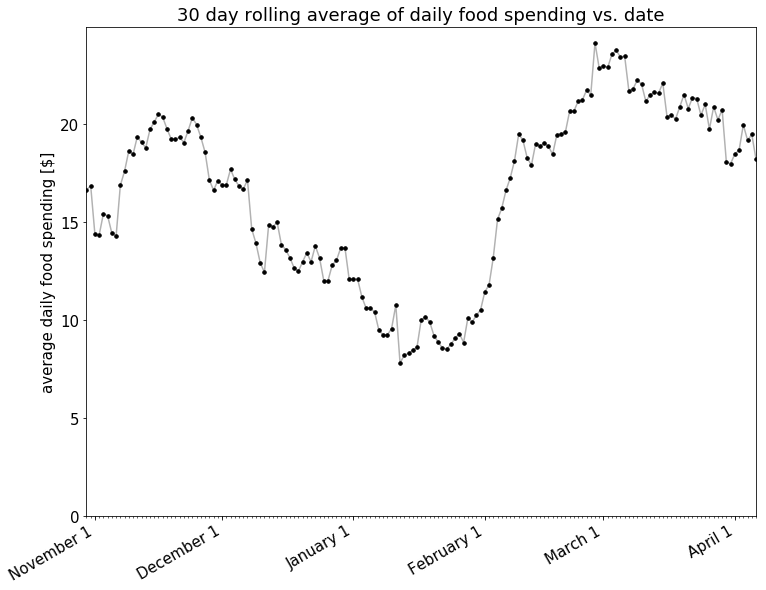

In [15]:
fig, ax = plt.subplots(1)

ax.plot(rolling_dates,rolling,'k', alpha=0.3)
ax.plot(rolling_dates,rolling,'k.', markersize=7)

format_x_axis_dates(fig, ax)

plt.ylabel("average daily food spending [$]")

ax.set_xlim([rolling_dates[0],rolling_dates[-1]])
ax.set_ylim(0)
ax.set_title("{} day rolling average of daily food spending vs. date".format(time_span))

plt.show()

Nothing definitive at this point.  It's clear that my spending went up through February and 
March.  I do remember clearly being surprised at how much I was spending on food in February when I looked (which is what prompted my changes).

It also does appear that there is a decline in spending starting around March.  Let's look at the trend in 30 day moving average starting March 1st.

In [16]:
def calculate_moving_average_with_regression(dates, daily_sums, time_span, linear_reg_start):

    rolling_dates,rolling = calculate_rolling_window_sums(dates, daily_sums, time_span)

    linear_reg_end = rolling_dates[-1]

    linear_reg_start_index = rolling_dates.index(linear_reg_start)

    date_nums = [mdates.date2num(dt) for dt in rolling_dates[linear_reg_start_index:]]
    float_nums = [float(num) for num in rolling[linear_reg_start_index:]]

    m,b = np.polyfit(date_nums,float_nums,1)

    lin_reg_x = [linear_reg_start, linear_reg_end]
    lin_reg_y = [mdates.date2num(linear_reg_start)*m+b, mdates.date2num(linear_reg_end)*m+b]
    
    return rolling_dates, rolling, lin_reg_x, lin_reg_y, m

In [17]:
def plot_moving_average_with_regression(rolling_dates, rolling, lin_reg_x, lin_reg_y, m):
    fig, ax = plt.subplots(1)
    ax.plot(rolling_dates,rolling,'k', alpha=0.3)
    ax.plot(rolling_dates,rolling,'k.', markersize=7)

    format_x_axis_dates(fig, ax)

    plt.ylabel("average daily food spending [$]")
    ax.set_xlim([lin_reg_x[0] - timedelta(days=35), rolling_dates[-1]])
    ax.set_ylim(0)
    ax.set_title("{} day rolling average of daily food spending vs. date".format(time_span))
    ax.plot(lin_reg_x,
            lin_reg_y,
            'r--',
            label="linear regession {} to {}".format(lin_reg_x[0].strftime("%m/%d/%y"),
                                                     lin_reg_x[1].strftime("%m/%d/%y")))
    ax.legend(loc=3)

    ax.annotate("slope = -${0:.2f} / day".format(abs(m)), 
                xytext=(datetime(day=1,month=3,year=2017), 10), 
                xy=(lin_reg_x[0], lin_reg_y[0]),
                xycoords='data',
                ha='right',
                va='center',
                arrowprops=dict(facecolor='red', shrink=0.05))

    plt.show()

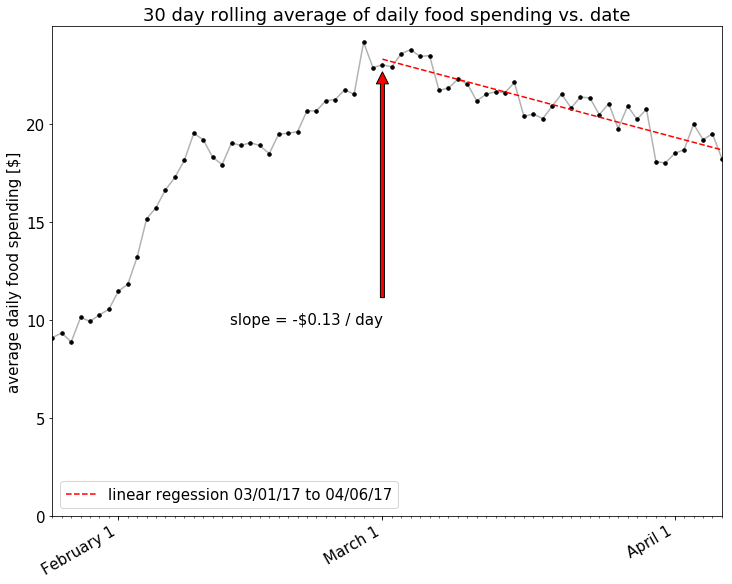

In [18]:
time_span = 30

plot_moving_average_with_regression(
    *calculate_moving_average_with_regression(dates, 
                                              daily_sums, 
                                              time_span, 
                                              datetime(day=1,month=3,year=2017)))


There looks to be a nice downward trend there!  How about if we look at an even shorter window, maybe only a 7 day moving average, to account for the relatively short amount of time that I've been making this effort?

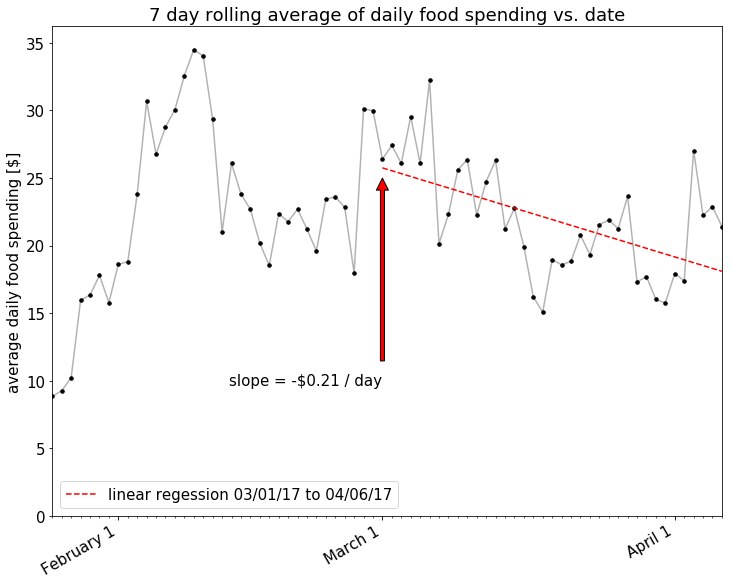

In [19]:
time_span = 7

plot_moving_average_with_regression(
    *calculate_moving_average_with_regression(dates, 
                                              daily_sums, 
                                              time_span, 
                                              datetime(day=1,month=3,year=2017)))

Looks like the effect is larger with the shorter time rolling average, but the correlation is much less strong.  In any case, it does appear that there's been some spending reduction over the last month or so.  I'll call it a tentative success.

So at first glance, it appears that my spending is going down.  However, I'm also interested in whether my spending is moving within the overall food category.  Specifically, I'm looking for my spending to transition from low-value (Restaurants, Lunch at Work) to more economic categories (Groceries).

Back to the overall time period, let's examine a stacked chart, showing how my spending is changing per category as well.

In [20]:
def calculate_rolling_window_stacked(dates, daily_sums, time_span):

    # index will be the date that we'll use to loop through our data
    # it starts n days from the beginning, which the first day that we
    # have enough data to average.  index is the end of our window
    # on each calculation
    start = dates[0]
    end = dates[-1]
    
    index = start + timedelta(days = time_span-1)

    rolling = []
    rolling_dates = []
    
    # stop once the index has reached the last day, stop calculating.
    while index <= end:

        # on each loop, filter out any transactions that don't fall in our window
        window = [trans for trans in transactions
                  if index - timedelta(days = time_span) <= trans.date <= index]

        # re-sort each window of transactions by category
        window = sorted(list(window), key = lambda trans: trans.category)
    
        # place those averages into a dictionary
        # then we can extract them in the same order each time
        # initialize each category to 0
        stack = {cat:0 for cat in food_categories}
        for cat,cat_trans in groupby(window, lambda trans: trans.category):
            stack[cat] = float(sum([trans.amount for trans in cat_trans])/time_span)
        
        # make a list of all the stacked numbers
        rolling.append([stack[cat] for cat in food_categories])

        # we're also keeping track of the dates for plotting later
        rolling_dates.append(index)

        # move the index date for the next iteration
        index = index + timedelta(days = 1)
        
    # return the date and sums lists
    return [rolling_dates, rolling]


In [21]:
def reverse_legend_labels(axis):
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles = k[::-1], labels = food_categories[::-1], prop={'size':10}, loc=2)

In [22]:
def add_braces(ax, date, stack_indices, dates, stack_data):
    date_index = dates.index(date)
    
    accu = list(accumulate([stack_data[i][date_index] for i in range(len(stack_data))]))
    
    for stack in stack_indices:
        text = "{0:.1f}%".format(accu[stack+1]-accu[stack])
        x0 = date - timedelta(days = 8)
        y0 = (accu[stack+1]-accu[stack])/2 + accu[stack]
        x1 = date
        y1 = accu[stack]
        y2 = accu[stack+1]
        
        arrowprops = dict(arrowstyle="->",
                          connectionstyle="arc, armB=-30")

        kwargs =dict(xycoords='data',
                     ha='right',
                     va='center',
                     bbox=dict(boxstyle='square', fc='white'),
                     arrowprops=arrowprops)

        ax.annotate(text, xy=(x1,y2), xytext=(x0,y0), **kwargs)
        ax.annotate(text, xy=(x1,y1), xytext=(x0,y0), **kwargs)
        

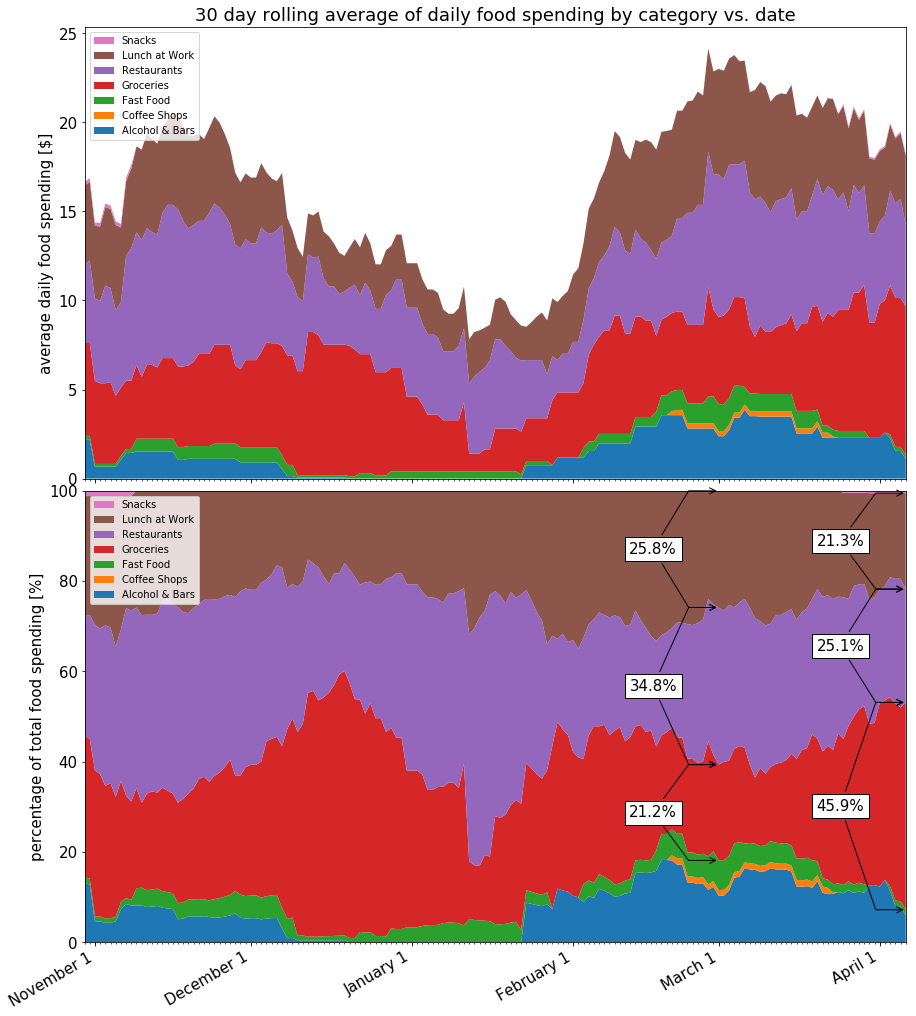

In [23]:
time_span = 30
    
rolling_dates,rolling = calculate_rolling_window_stacked(dates, daily_sums, time_span)
    
y = np.row_stack(list(zip(*rolling)))
percent = y /  y.sum(axis=0).astype(float) * 100 

fig, (ax2, ax) = plt.subplots(2, facecolor='white', sharex=True, figsize=(12,16))
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)

k = ax.stackplot(rolling_dates, percent)
k = ax2.stackplot(rolling_dates, y)

reverse_legend_labels(ax)
reverse_legend_labels(ax2)

ax.set_ylabel("percentage of total food spending [%]")
ax.set_xlim([rolling_dates[0],rolling_dates[-1]])
ax.set_ylim([0,100])

format_x_axis_dates(fig, ax2)

ax2.set_title("{} day rolling average of daily food spending by category vs. date".format(time_span))
ax2.set_ylabel("average daily food spending [$]")
    
add_braces(ax, datetime(day=1,month=3,year=2017), [2,3,4], rolling_dates, percent)
add_braces(ax, rolling_dates[-1], [2,3,4], rolling_dates, percent)
    
plt.show()

## Summary

From the data that I've seen, I'd call it a moderate success so far, but an extra month or two of data will confirm whether it's a lasting trend or just a fluctuation in the data from other sources.

The 30 day MA over the last 5 weeks shows a clear downward trend, the 7 day MA shows a larger downward trend (albeit with a weaker correlation), and the 100% stacked chart shows that my spending has shifted in the way that I was hoping.

[^floating_bitcoin]: As an aside, here's a fun example of what can happen if you store currencies as floating point numbers: https://hackerone.com/reports/176461

[^wiki_ma]: https://en.wikipedia.org/wiki/Moving_average